In [1]:
import pandas as pd
import numpy as np
import json
import joblib
import random

In [2]:
def read_data():
    tmp = []
    for i in range(1,191961+1):
        print(i)
        f = open(f"E:\\deepfashion_data\\train\\annos\\{i:06d}.json", "r")
        data = json.load(f)
        items = [ i for i in data.keys() if i.startswith("item")]
        for item in items:
            data[item]["image"] = f"E:\\deepfashion_data\\train\\image\\{i:06d}.jpg"
            data[item]["pair_id"] = data["pair_id"]
            data[item]["source"] = data["source"]
            tmp.append(data[item])
    return pd.DataFrame(tmp)

#df = read_data()

In [3]:
# joblib.dump(df, "deepfashion_train.joblib")
df = joblib.load("deepfashion_train.joblib")

# Example images and bounding boxes:

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.patches as patches

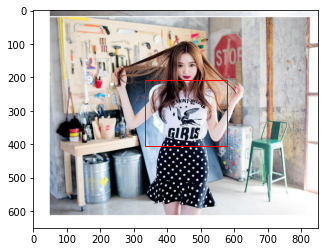

In [5]:
def plot_index(i):
    image = img.imread(df.loc[i,"image"])
    bounding = df.loc[i,"bounding_box"]
    plt.imshow(image)
    tmpimg = plt.gca()
    rect = patches.Rectangle((bounding[0],bounding[1]),bounding[2]-bounding[0],bounding[3]-bounding[1], linewidth=1, edgecolor="r", facecolor="none")
    tmpimg.add_patch(rect)
    plt.show()

plot_index(899)

## Transform to input images

In [6]:
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

In [7]:
def get_array_for_item(i):
    im = Image.open(df.loc[i,"image"])
    bounding = df.loc[i,"bounding_box"]
    imc = im.crop( ( bounding[0], bounding[1], bounding[2], bounding[3] ) ).resize((600,600))
    x = image.img_to_array(imc)
    x = np.expand_dims(x, axis=0)
    return preprocess_input(x)

get_array_for_item(899).shape

(1, 600, 600, 3)

## Now we need some training pairs...

Lets limit ourselves to only one category ... lets say 1. End lets only take the first 1000 unique items.

In [20]:
cat1 = df[df["category_id"]==1]
unique_pair_id = cat1["pair_id"].unique()

pairs = []

for u in unique_pair_id[:100]:
    tmp = list(cat1[cat1["pair_id"]==u].index)
    for i in range(len(tmp)-1):
        a = tmp[i]
        for b in tmp[i+1:]:
            pairs.append((a,b))
        
print(len(pairs))
random.shuffle(pairs)

7966


Now get some negative pairs, too.

In [9]:
import random

In [21]:
tmp = cat1[cat1["pair_id"] < unique_pair_id[100]].index
negative_pairs = []
while len(negative_pairs) < len(pairs):
    t = random.choices(tmp, k=2)
    if t[0] != t[1] and cat1.loc[t[0],"pair_id"] != cat1.loc[t[1], "pair_id"]:
        negative_pairs.append(tuple(t))
print(len(negative_pairs))
random.shuffle(negative_pairs)

7966


In [11]:
def get_batch(batch_size, offset=0):
    X_pairs = [ np.empty((batch_size, 600, 600, 3)) for i in range(2) ]
    targets = np.zeros((batch_size,1))
    
    targets[:batch_size//2] = 1
    for i in range(batch_size):
        if i < batch_size//2:
            X_pairs[0][i] = get_array_for_item(pairs[offset+i][0])
            X_pairs[1][i] = get_array_for_item(pairs[offset+i][1])
        else:
            X_pairs[0][i] = get_array_for_item(negative_pairs[offset+i][0])
            X_pairs[1][i] = get_array_for_item(negative_pairs[offset+i][1])
    return X_pairs, targets

tmp_pairs, tmp_targets = get_batch(11)
print(tmp_pairs[0].shape)
print(tmp_targets)

(11, 600, 600, 3)
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [12]:
def batch_generator(batch_size):
    for i in range(len(pairs)//batch_size):
        p, t = get_batch(batch_size, offset=i*batch_size)
        yield (p, t)

In [29]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications.efficientnet import decode_predictions
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

# effnet = EfficientNetB7(weights='imagenet')

In [14]:
# # img_path = 'shoe.png'
# # img = image.load_img(img_path, target_size=(600, 600))
# # print(img)

# tmp = K.constant(get_array_for_item(899))

# preds = effnet.predict(tmp)
# # decode the results into a list of tuples (class, description, probability)
# # (one such list for each sample in the batch)
# print('Predicted:', decode_predictions(preds, top=3)[0])
# # Predicted: [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker', 0.1122357), (u'n02504458', u'African_elephant', 0.061040461)]

Lets freeze everything but the last layer for training:

In [15]:
def get_siamese_model(input_shape):
    """
        Model architecture
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Pretrained Convolutional Neural Network
    effnet = EfficientNetB7(weights='imagenet')
    for layer in effnet.layers[:-1]:
        layer.trainable = False
    effnet.layers[-1].trainable = True
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = effnet(left_input)
    encoded_r = effnet(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

model = get_siamese_model((600,600,3,))

In [18]:
model.summary()
model.compile(loss="binary_crossentropy", optimizer="adam", metrics="accuracy")

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600, 600, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 600, 600, 3) 0                                            
__________________________________________________________________________________________________
efficientnetb7 (Functional)     (None, 1000)         66658687    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1000)         0           efficientnetb7[0][0]  

In [25]:
batch_size=16
model.fit( batch_generator(batch_size), steps_per_epoch=len(pairs)//batch_size, epochs=10 )

Epoch 1/10
 15/497 [..............................] - ETA: 11:43 - loss: 0.6739 - accuracy: 0.6083

KeyboardInterrupt: 